In [9]:
import os
import sys
import yaml

from glob import glob
from tqdm.auto import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from PIL import Image

# Pytorch StarDist3D
sys.path.append('..')
from pytorch_stardist.data.utils import normalize
from pytorch_stardist.models.config import Config3D
from pytorch_stardist.models.stardist3d import StarDist3D
from utils import seed_all, prepare_conf

from stardist_tools.matching import matching_dataset
from evaluate import evaluate

# Need this even when not using multiprocessing
os.environ["LOCAL_RANK"] = '0'
os.environ["RANK"] = '0'

In [10]:
config_file = '../confs/train_convnext_unet_base-3D.yaml'

with open(config_file) as yconf:
    opt = yaml.safe_load(yconf)

Config = Config3D
StarDist = StarDist3D

conf = Config(**opt, allow_new_params=True)

# Set random seed
seed_all(conf.random_seed)

# process the configuration variables
opt = prepare_conf(conf)

# Model instanciation
model = StarDist(opt)
#model.net.load_state_dict(torch.load('../model_checkpoints/convnext_unet_base-3D.pth'))
model.net.load_state_dict(torch.load('../../nuclear_segmentation/experiments/model_checkpoints/convnext_unet_base-3D/best.pth')['model_state_dict'])
model.net.to(model.device)

model.thresholds['prob'] = 0.5
model.thresholds['nms'] = 0.3

In [ ]:
# state_dict = torch.load('../../nuclear_segmentation/experiments/model_checkpoints/convnext_unet_base-3D/best.pth')['model_state_dict']
# print(state_dict['encoder.downsample_layers.0.0.native_conv.weight'].shape)
# state_dict['encoder.downsample_layers.0.0.native_conv.weight'] = state_dict['encoder.downsample_layers.0.0.native_conv.weight'].repeat(1, 3, 1, 1, 1)
# torch.save(state_dict, '../model_checkpoints/convnext_unet_base-4D_channels-starting.pth')

torch.Size([64, 1, 4, 4, 4])


In [4]:
sum(p.numel() for p in model.parameters())

135295201

In [5]:
class BlastospimDataset(Dataset):
    def __init__(self, image_names, source_dir):
        self.image_paths = []
        self.mask_paths = []
        for name in image_names:
            self.image_paths.append(f'{source_dir}/{name}/{name}/images/{name}_image_0001.npy')
            self.mask_paths.append(f'{source_dir}/{name}/{name}/masks/{name}_masks_0001.npy')

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        image = np.load(image_path)
        mask = np.load(mask_path)

        # Make image dimensions divisible by n:
        n = 32
        image = image[:image.shape[0]-image.shape[0]%n, :image.shape[1]-image.shape[1]%n, :image.shape[2]-image.shape[2]%n]
        mask = mask[:mask.shape[0]-mask.shape[0]%n, :mask.shape[1]-mask.shape[1]%n, :mask.shape[2]-mask.shape[2]%n]
        assert image.shape == mask.shape

        # Normalize image
        axis_norm = (0, 1, 2)  # normalize channels independently
        image = np.expand_dims(normalize(image, 1, 99.8, axis=axis_norm), 0) # Add channel for one color

        return {
            'image':image.astype(np.float32),
            'mask':mask.astype(np.int16)
        }

In [6]:
testset8 = ['F24_001', 'F24_002', 'F24_006', 'F25_002', 'F25_008', 'F27_010', 'F27_007', 'F27_009', 'F29_003','F29_004', 'F30_004', 'F30_008', 'F30_009', 'M6_021', 'M6_012']
testset16 = ['M7_004', 'M7_000', 'F42_063', 'F41_056', 'F34_073', 'F33_067', 'F26_008', 'F24_010']
testset32 = ['F8_072', 'F44_087', 'F44_089', 'F39_117']
testset64 = ['F40_136', 'F49_148']
testset128 = ['F55_185']

testset2_lowsnr = ['F11_070','F11_071']
testset4_lowsnr = ['T1_003', 'T1_004']
testset8_lowsnr = ['H1_003','H1_005','H1_006','H2_011','H2_012','H3_000','H3_002','H3_007','H3_009','H5_004','H5_007','H5_009','H6_016','H7_002','H7_004','H7_007','H7_008','H8_011','H8_016','H8_018','H9_000','H9_001','H9_010','H9_008','M14_016','M3_002','M3_003','M3_008','M4_011','M4_012','M4_013','M4_017','M14_018']
testset16_lowsnr = ['M14_019','M14_020','H2_016','H8_021','H4_011','H4_012','F16_068','F16_069','F16_070','F16_072','H4_013','M10_012','M10_015','M10_018','M7_007','M7_008','M8_014','M8_015','M8_016']
testset32_lowsnr = ['F9_071','F9_074']
testset64_lowsnr = ['F2_013','F2_012']

source_dir = '/mnt/ceph/users/alu10/datasets/GTSets/2023_Full_Iso-Trilinear_Image'

In [7]:
def generate_masks(dataset):
    test_dataset = BlastospimDataset(dataset, source_dir)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    predicted_labels = []
    gt_masks = []
    gt_images = []
    
    for batch in tqdm(test_dataloader):
        image, mask = batch['image'][0].numpy(), batch['mask'][0].numpy()
        labels, details = model.predict_instance(image, patch_size=[256, 256, 256], context=[64, 64, 64]) 
        predicted_labels.append(labels)
        gt_masks.append(mask)
        gt_images.append(image)
        
    return predicted_labels, gt_masks, gt_images


# Run for each stage
print('Generating masks for 8 nuceli stage')
predicted_labels_8, gt_masks_8, gt_images_8 = generate_masks(testset8)

print('Generating masks for 16 nuceli stage')
predicted_labels_16, gt_masks_16, gt_images_16 = generate_masks(testset16)

print('Generating masks for 32 nuceli stage')
predicted_labels_32, gt_masks_32, gt_images_32 = generate_masks(testset32)

print('Generating masks for 64 nuceli stage')
predicted_labels_64, gt_masks_64, gt_images_64 = generate_masks(testset64)

print('Generating masks for 128 nuceli stage')
predicted_labels_128, gt_masks_128, gt_images_128 = generate_masks(testset128)

Generating masks for 8 nuceli stage


  0%|          | 0/15 [00:00<?, ?it/s]

Generating masks for 16 nuceli stage


  0%|          | 0/8 [00:00<?, ?it/s]

Generating masks for 32 nuceli stage


  0%|          | 0/4 [00:00<?, ?it/s]

Generating masks for 64 nuceli stage


  0%|          | 0/2 [00:00<?, ?it/s]

Generating masks for 128 nuceli stage


  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# Define the IoU thresholds and initialize results dictionary
iou_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
results = {
    'IoU Threshold': [],
    'Precision (8 nuclei)': [],
    'Recall (8 nuclei)': [],
    'Precision (16 nuclei)': [],
    'Recall (16 nuclei)': [],
    'Precision (32 nuclei)': [],
    'Recall (32 nuclei)': [],
    'Precision (64 nuclei)': [],
    'Recall (64 nuclei)': [],
    'Precision (128 nuclei)': [],
    'Recall (128 nuclei)': [],
}

# Helper function to compute stats for a given threshold
def compute_stats(gt, pred, thresh):
    stats = matching_dataset(gt, pred, thresh=thresh, show_progress=False)
    return stats.precision, stats.recall

# Fill the results dictionary
for thresh in tqdm(iou_thresholds):
    p8, r8 = compute_stats(gt_masks_8, predicted_labels_8, thresh)
    p16, r16 = compute_stats(gt_masks_16, predicted_labels_16, thresh)
    p32, r32 = compute_stats(gt_masks_32, predicted_labels_32, thresh)
    p64, r64 = compute_stats(gt_masks_64, predicted_labels_64, thresh)
    p128, r128 = compute_stats(gt_masks_128, predicted_labels_128, thresh)

    results['IoU Threshold'].append(thresh)
    results['Precision (8 nuclei)'].append(p8)
    results['Recall (8 nuclei)'].append(r8)
    results['Precision (16 nuclei)'].append(p16)
    results['Recall (16 nuclei)'].append(r16)
    results['Precision (32 nuclei)'].append(p32)
    results['Recall (32 nuclei)'].append(r32)
    results['Precision (64 nuclei)'].append(p64)
    results['Recall (64 nuclei)'].append(r64)
    results['Precision (128 nuclei)'].append(p128)
    results['Recall (128 nuclei)'].append(r128)

# Convert to DataFrame and display
df_results = pd.DataFrame(results)
display(df_results)

  0%|          | 0/5 [00:00<?, ?it/s]

,IoU Threshold,Precision (8 nuclei),Recall (8 nuclei),Precision (16 nuclei),Recall (16 nuclei),Precision (32 nuclei),Recall (32 nuclei),Precision (64 nuclei),Recall (64 nuclei),Precision (128 nuclei),Recall (128 nuclei)
0,0.5,1.000000,0.984848,0.991379,0.982906,0.992188,1.000000,1.000000,1.000000,0.957895,0.892157
1,0.6,0.969231,0.954545,0.982759,0.974359,0.992188,1.000000,0.983607,0.983607,0.926316,0.862745
2,0.7,0.907692,0.893939,0.922414,0.914530,0.968750,0.976378,0.950820,0.950820,0.736842,0.686275
3,0.8,0.761538,0.750000,0.741379,0.735043,0.875000,0.881890,0.770492,0.770492,0.410526,0.382353
4,0.9,0.146154,0.143939,0.387931,0.384615,0.406250,0.409449,0.016393,0.016393,0.000000,0.000000


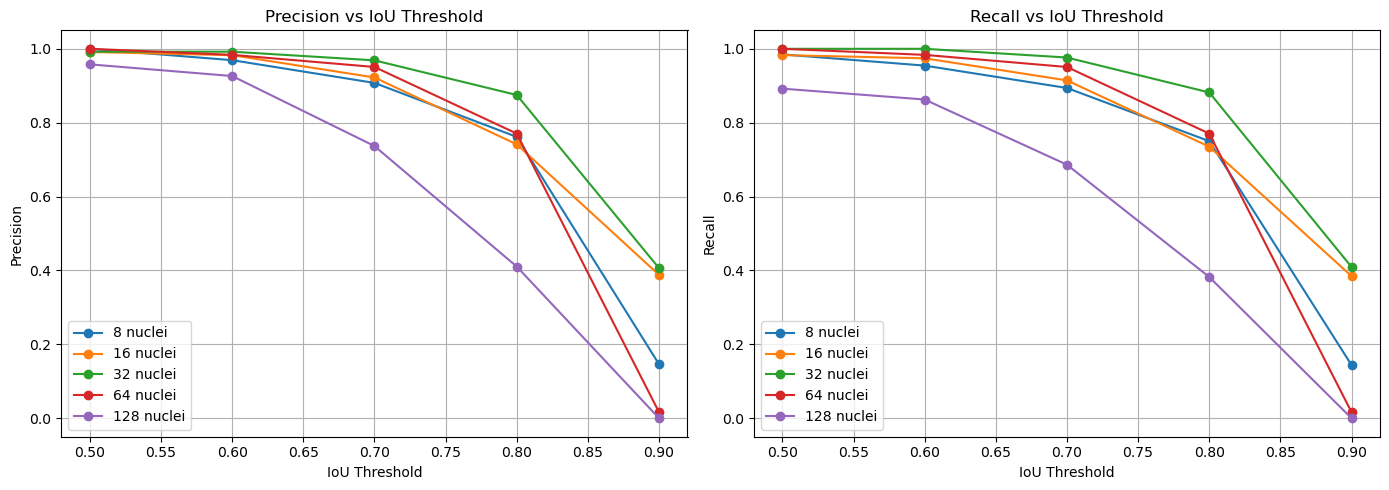

In [9]:
# Prepare the data
iou_thresholds = df_results['IoU Threshold'].values

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Plot Precision
axes[0].plot(iou_thresholds, df_results['Precision (8 nuclei)'], label='8 nuclei', marker='o')
axes[0].plot(iou_thresholds, df_results['Precision (16 nuclei)'], label='16 nuclei', marker='o')
axes[0].plot(iou_thresholds, df_results['Precision (32 nuclei)'], label='32 nuclei', marker='o')
axes[0].plot(iou_thresholds, df_results['Precision (64 nuclei)'], label='64 nuclei', marker='o')
axes[0].plot(iou_thresholds, df_results['Precision (128 nuclei)'], label='128 nuclei', marker='o')
axes[0].set_title('Precision vs IoU Threshold')
axes[0].set_xlabel('IoU Threshold')
axes[0].set_ylabel('Precision')
axes[0].grid(True)
axes[0].legend()

# Plot Recall
axes[1].plot(iou_thresholds, df_results['Recall (8 nuclei)'], label='8 nuclei', marker='o')
axes[1].plot(iou_thresholds, df_results['Recall (16 nuclei)'], label='16 nuclei', marker='o')
axes[1].plot(iou_thresholds, df_results['Recall (32 nuclei)'], label='32 nuclei', marker='o')
axes[1].plot(iou_thresholds, df_results['Recall (64 nuclei)'], label='64 nuclei', marker='o')
axes[1].plot(iou_thresholds, df_results['Recall (128 nuclei)'], label='128 nuclei', marker='o')
axes[1].set_title('Recall vs IoU Threshold')
axes[1].set_xlabel('IoU Threshold')
axes[1].set_ylabel('Recall')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()